<a href="https://colab.research.google.com/github/I-ULISES-I/Colabfiles/blob/main/Pr%C3%A1ctica_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica #25. Validación, Evaluación y Selección**

## **1. Carga de Bibliotecas, Conjunto de Datos y Análisis Exploratorio de los Datos**

In [47]:
#Importación de librerías.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Carga de conjunto de datos.
df = pd.read_csv('drive/MyDrive/ClassFiles/TCGA_InfoWithGrade.csv')

## **2. Análisis Exploratorio de Datos (EDA)**

In [48]:
#Impresión de descripción de datos.
print(df.shape, "\n")
print(df.describe(), "\n")
print(df.info(), "\n")

#
print(df['Grade'].value_counts())

(839, 24) 

            Grade      Gender  Age_at_diagnosis        Race        IDH1  \
count  839.000000  839.000000        839.000000  839.000000  839.000000   
mean     0.419547    0.418355         50.935411    0.107271    0.481526   
std      0.493779    0.493583         15.702339    0.369392    0.499957   
min      0.000000    0.000000         14.420000    0.000000    0.000000   
25%      0.000000    0.000000         38.055000    0.000000    0.000000   
50%      0.000000    0.000000         51.550000    0.000000    0.000000   
75%      1.000000    1.000000         62.800000    0.000000    1.000000   
max      1.000000    1.000000         89.290000    3.000000    1.000000   

             TP53        ATRX        PTEN        EGFR         CIC  ...  \
count  839.000000  839.000000  839.000000  839.000000  839.000000  ...   
mean     0.414779    0.258641    0.168057    0.133492    0.132300  ...   
std      0.492978    0.438149    0.374140    0.340309    0.339019  ...   
min      0.00000

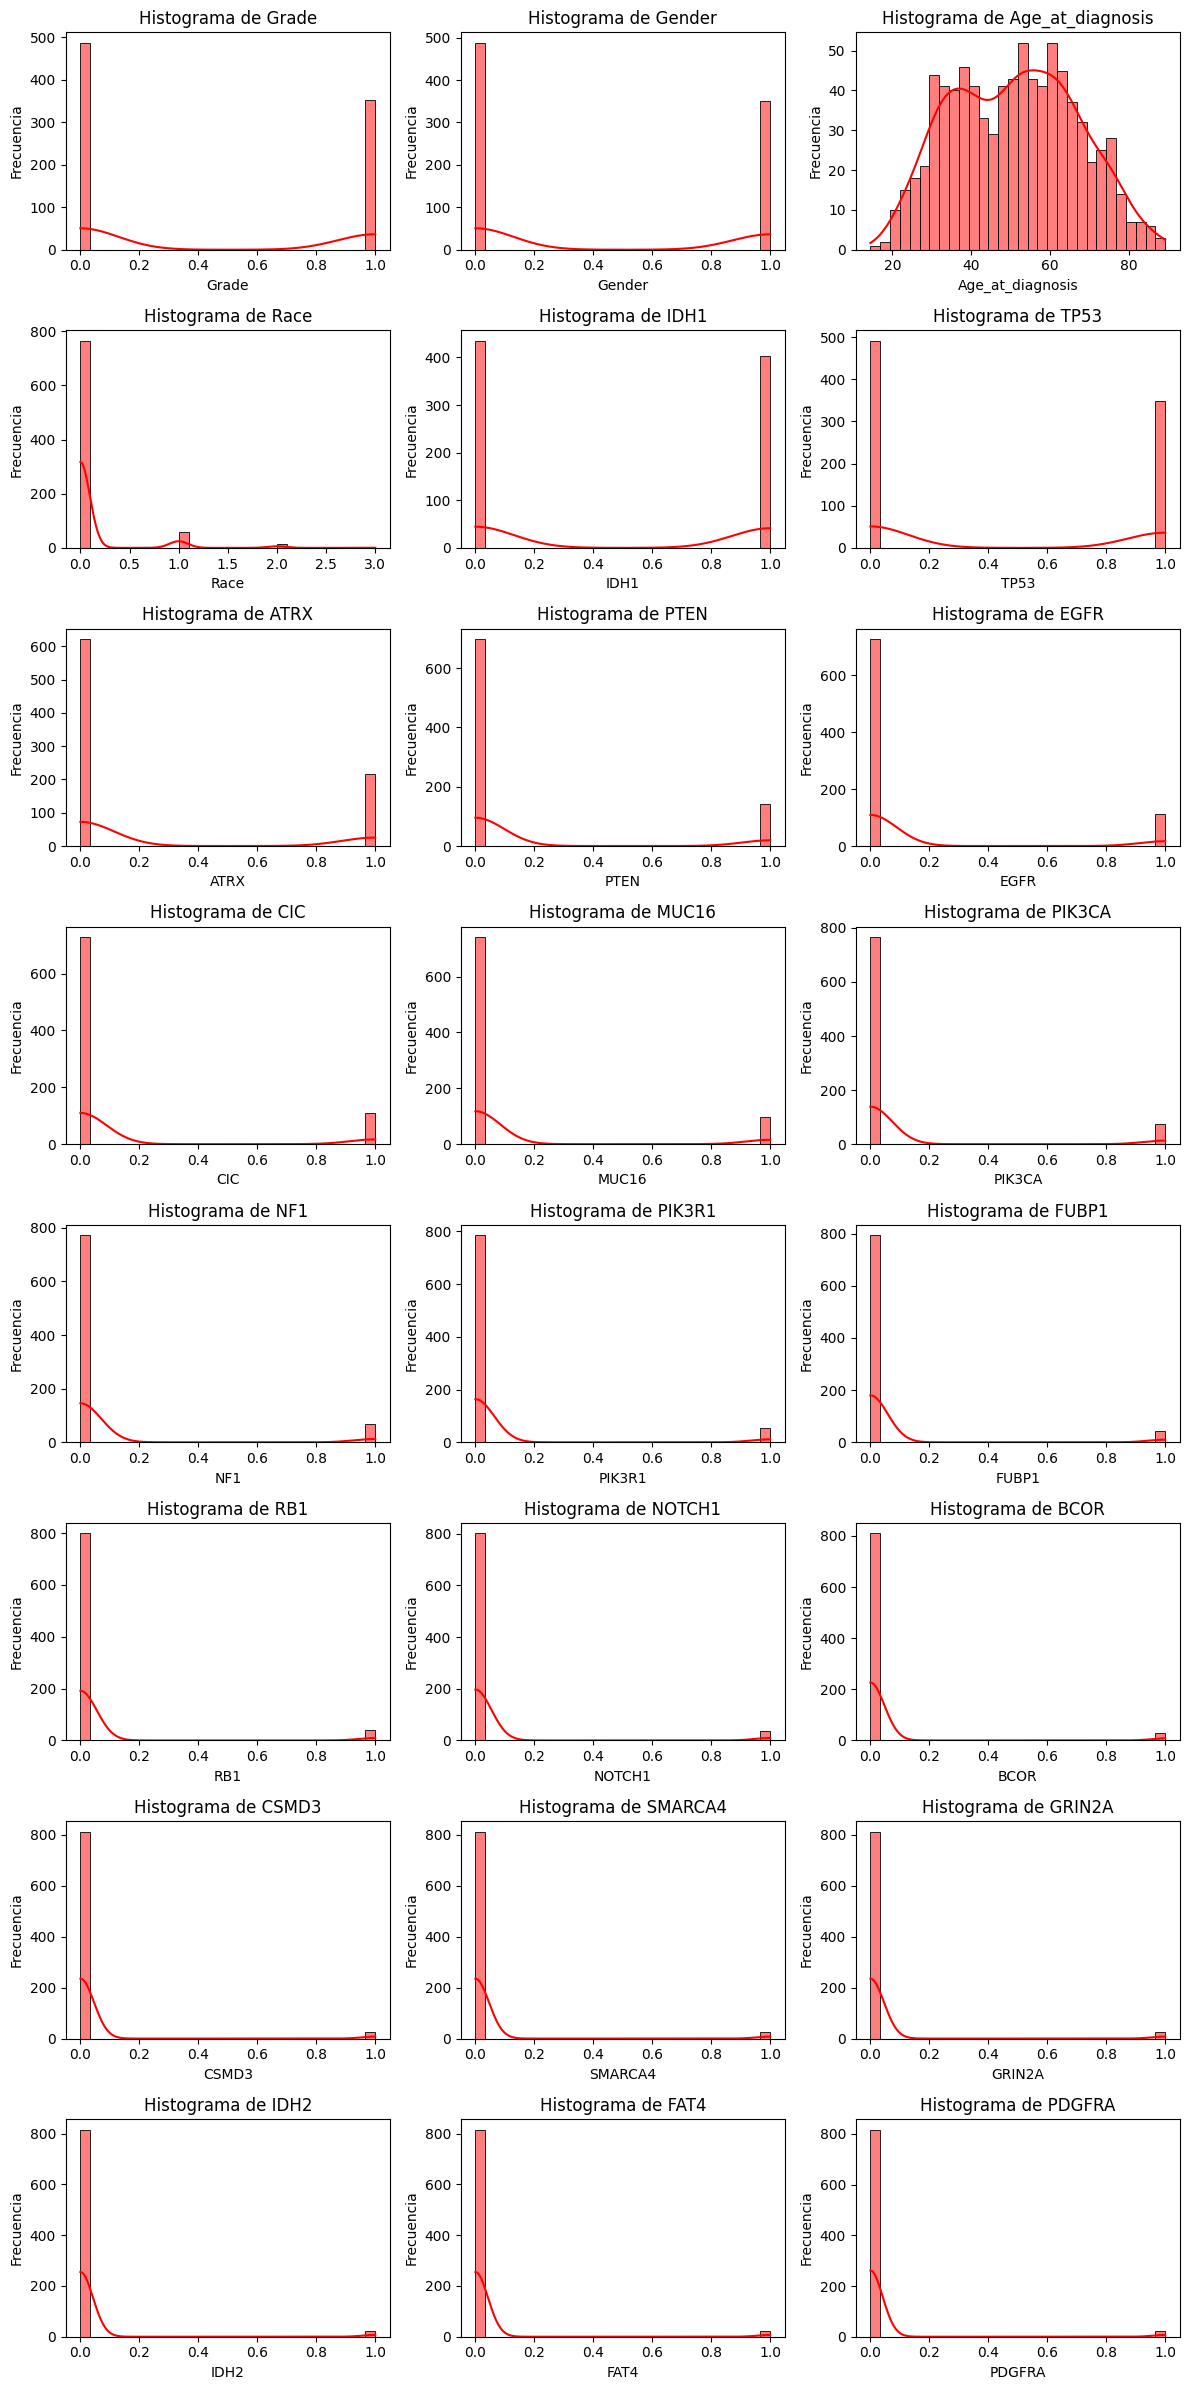

In [49]:
#Selección de variables númericas.
variables_numericas = df.select_dtypes(include=['int64', 'float64']).columns

#Creación y diseño de histogramas.
plt.figure(figsize=(12, 24))
for i, variable in enumerate(variables_numericas, 1):
  plt.subplot(8, 3, i)
  sns.histplot(df[variable], kde=True, bins=30, color='red')
  plt.title(f"Histograma de {variable}")
  plt.xlabel(variable)
  plt.ylabel("Frecuencia")

#Impresión de histogramas.
plt.tight_layout()
plt.show()

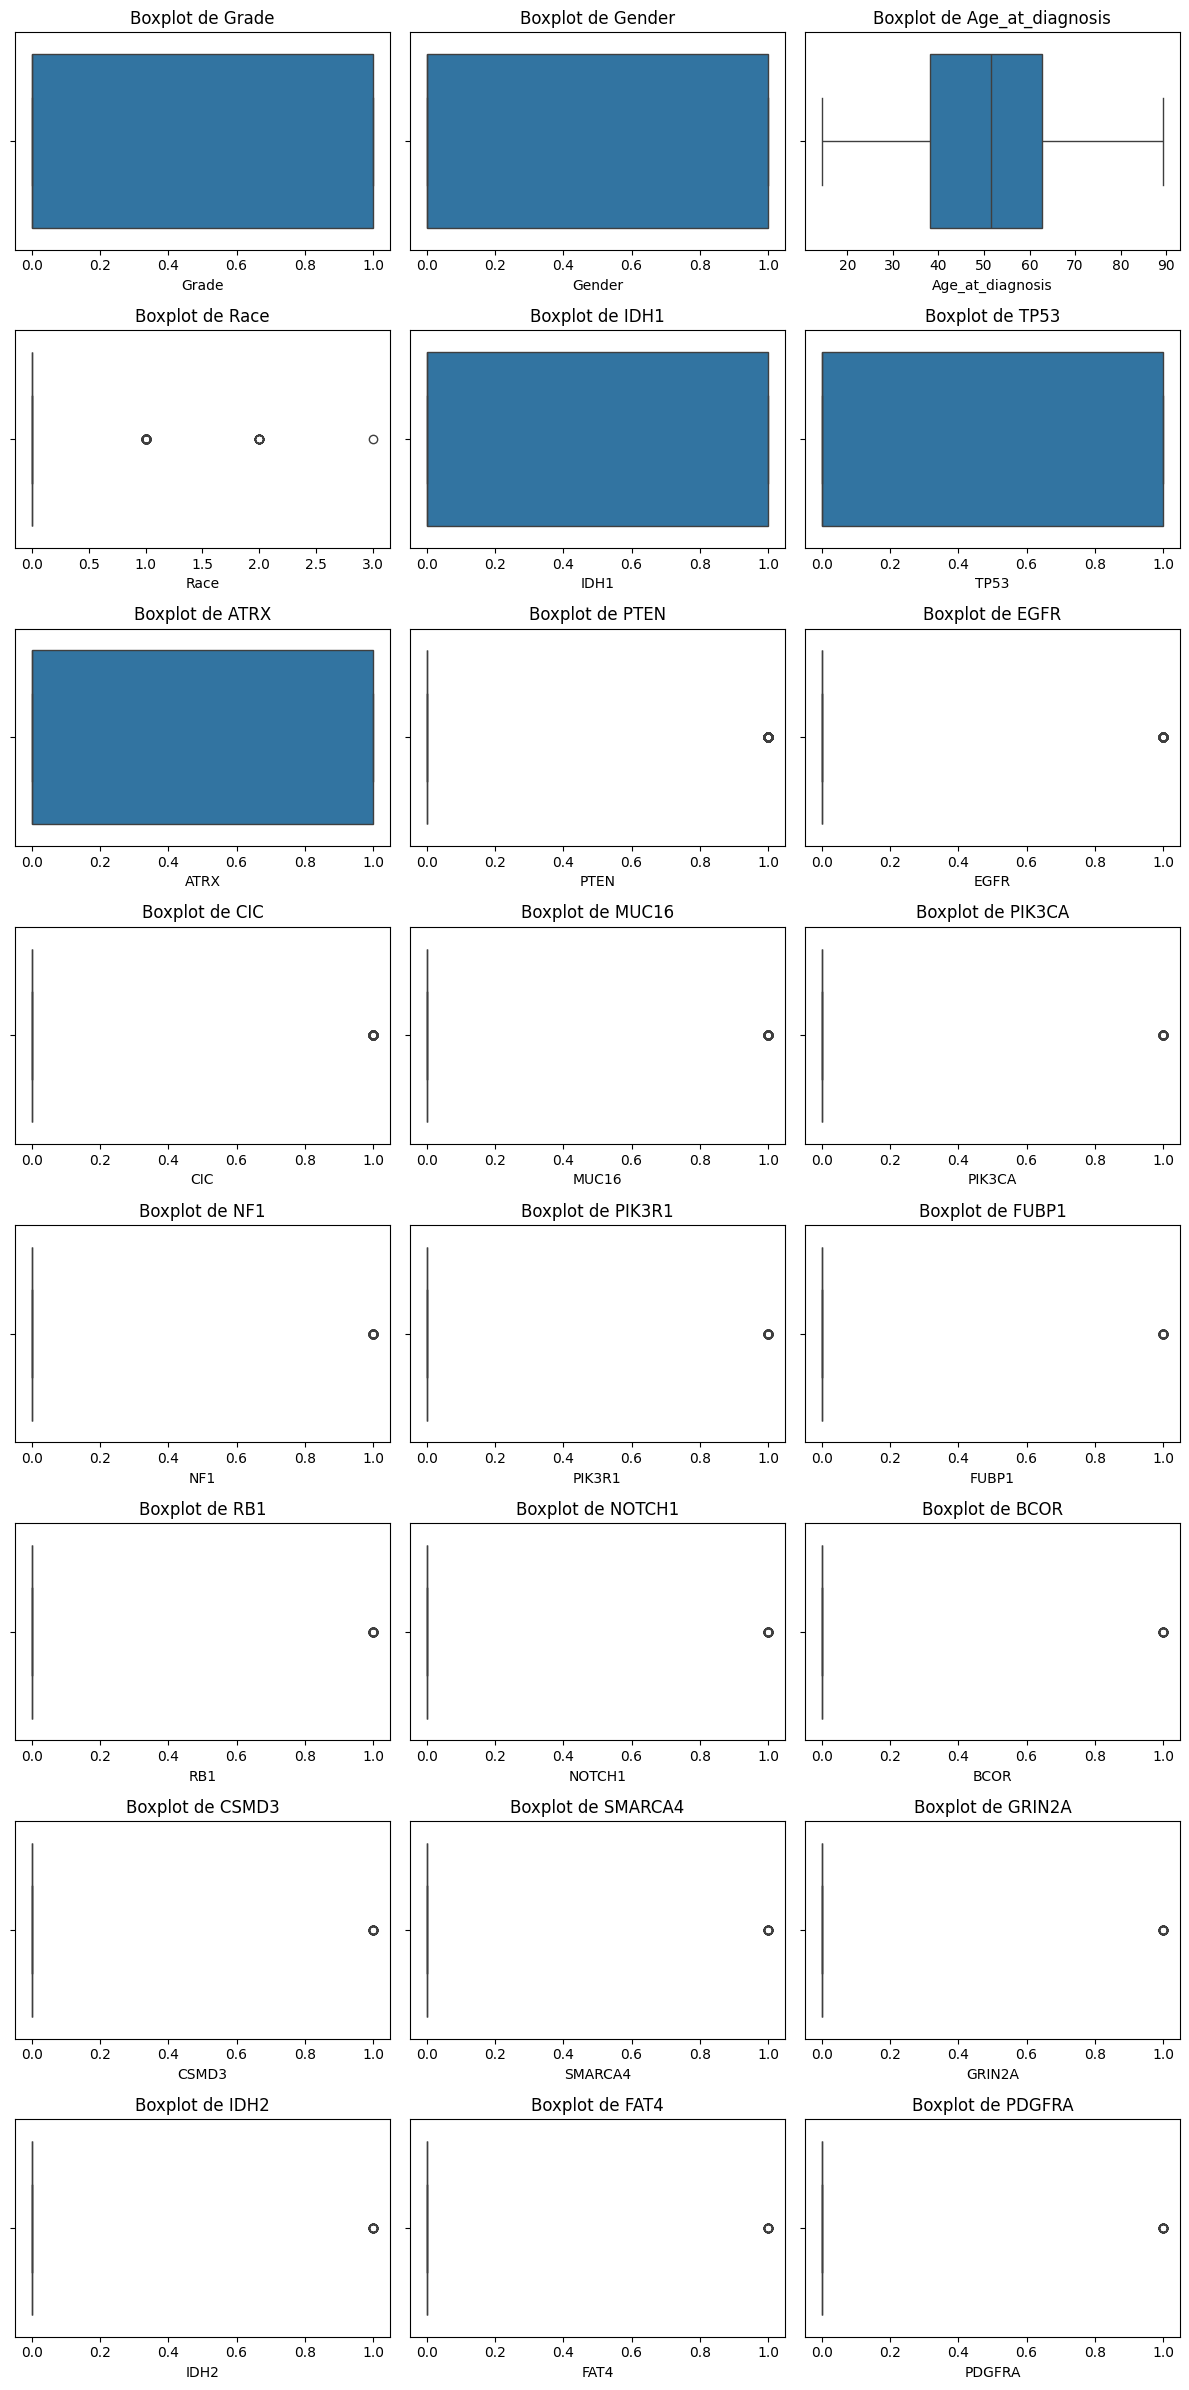

In [50]:
#Creación y diseño de boxplots.
plt.figure(figsize=(12, 24))
for i, variable in enumerate(variables_numericas, 1):
  plt.subplot(8, 3, i)
  sns.boxplot(x=df[variable])
  plt.title(f"Boxplot de {variable}")

#Impresión de boxplots.
plt.tight_layout()
plt.show()

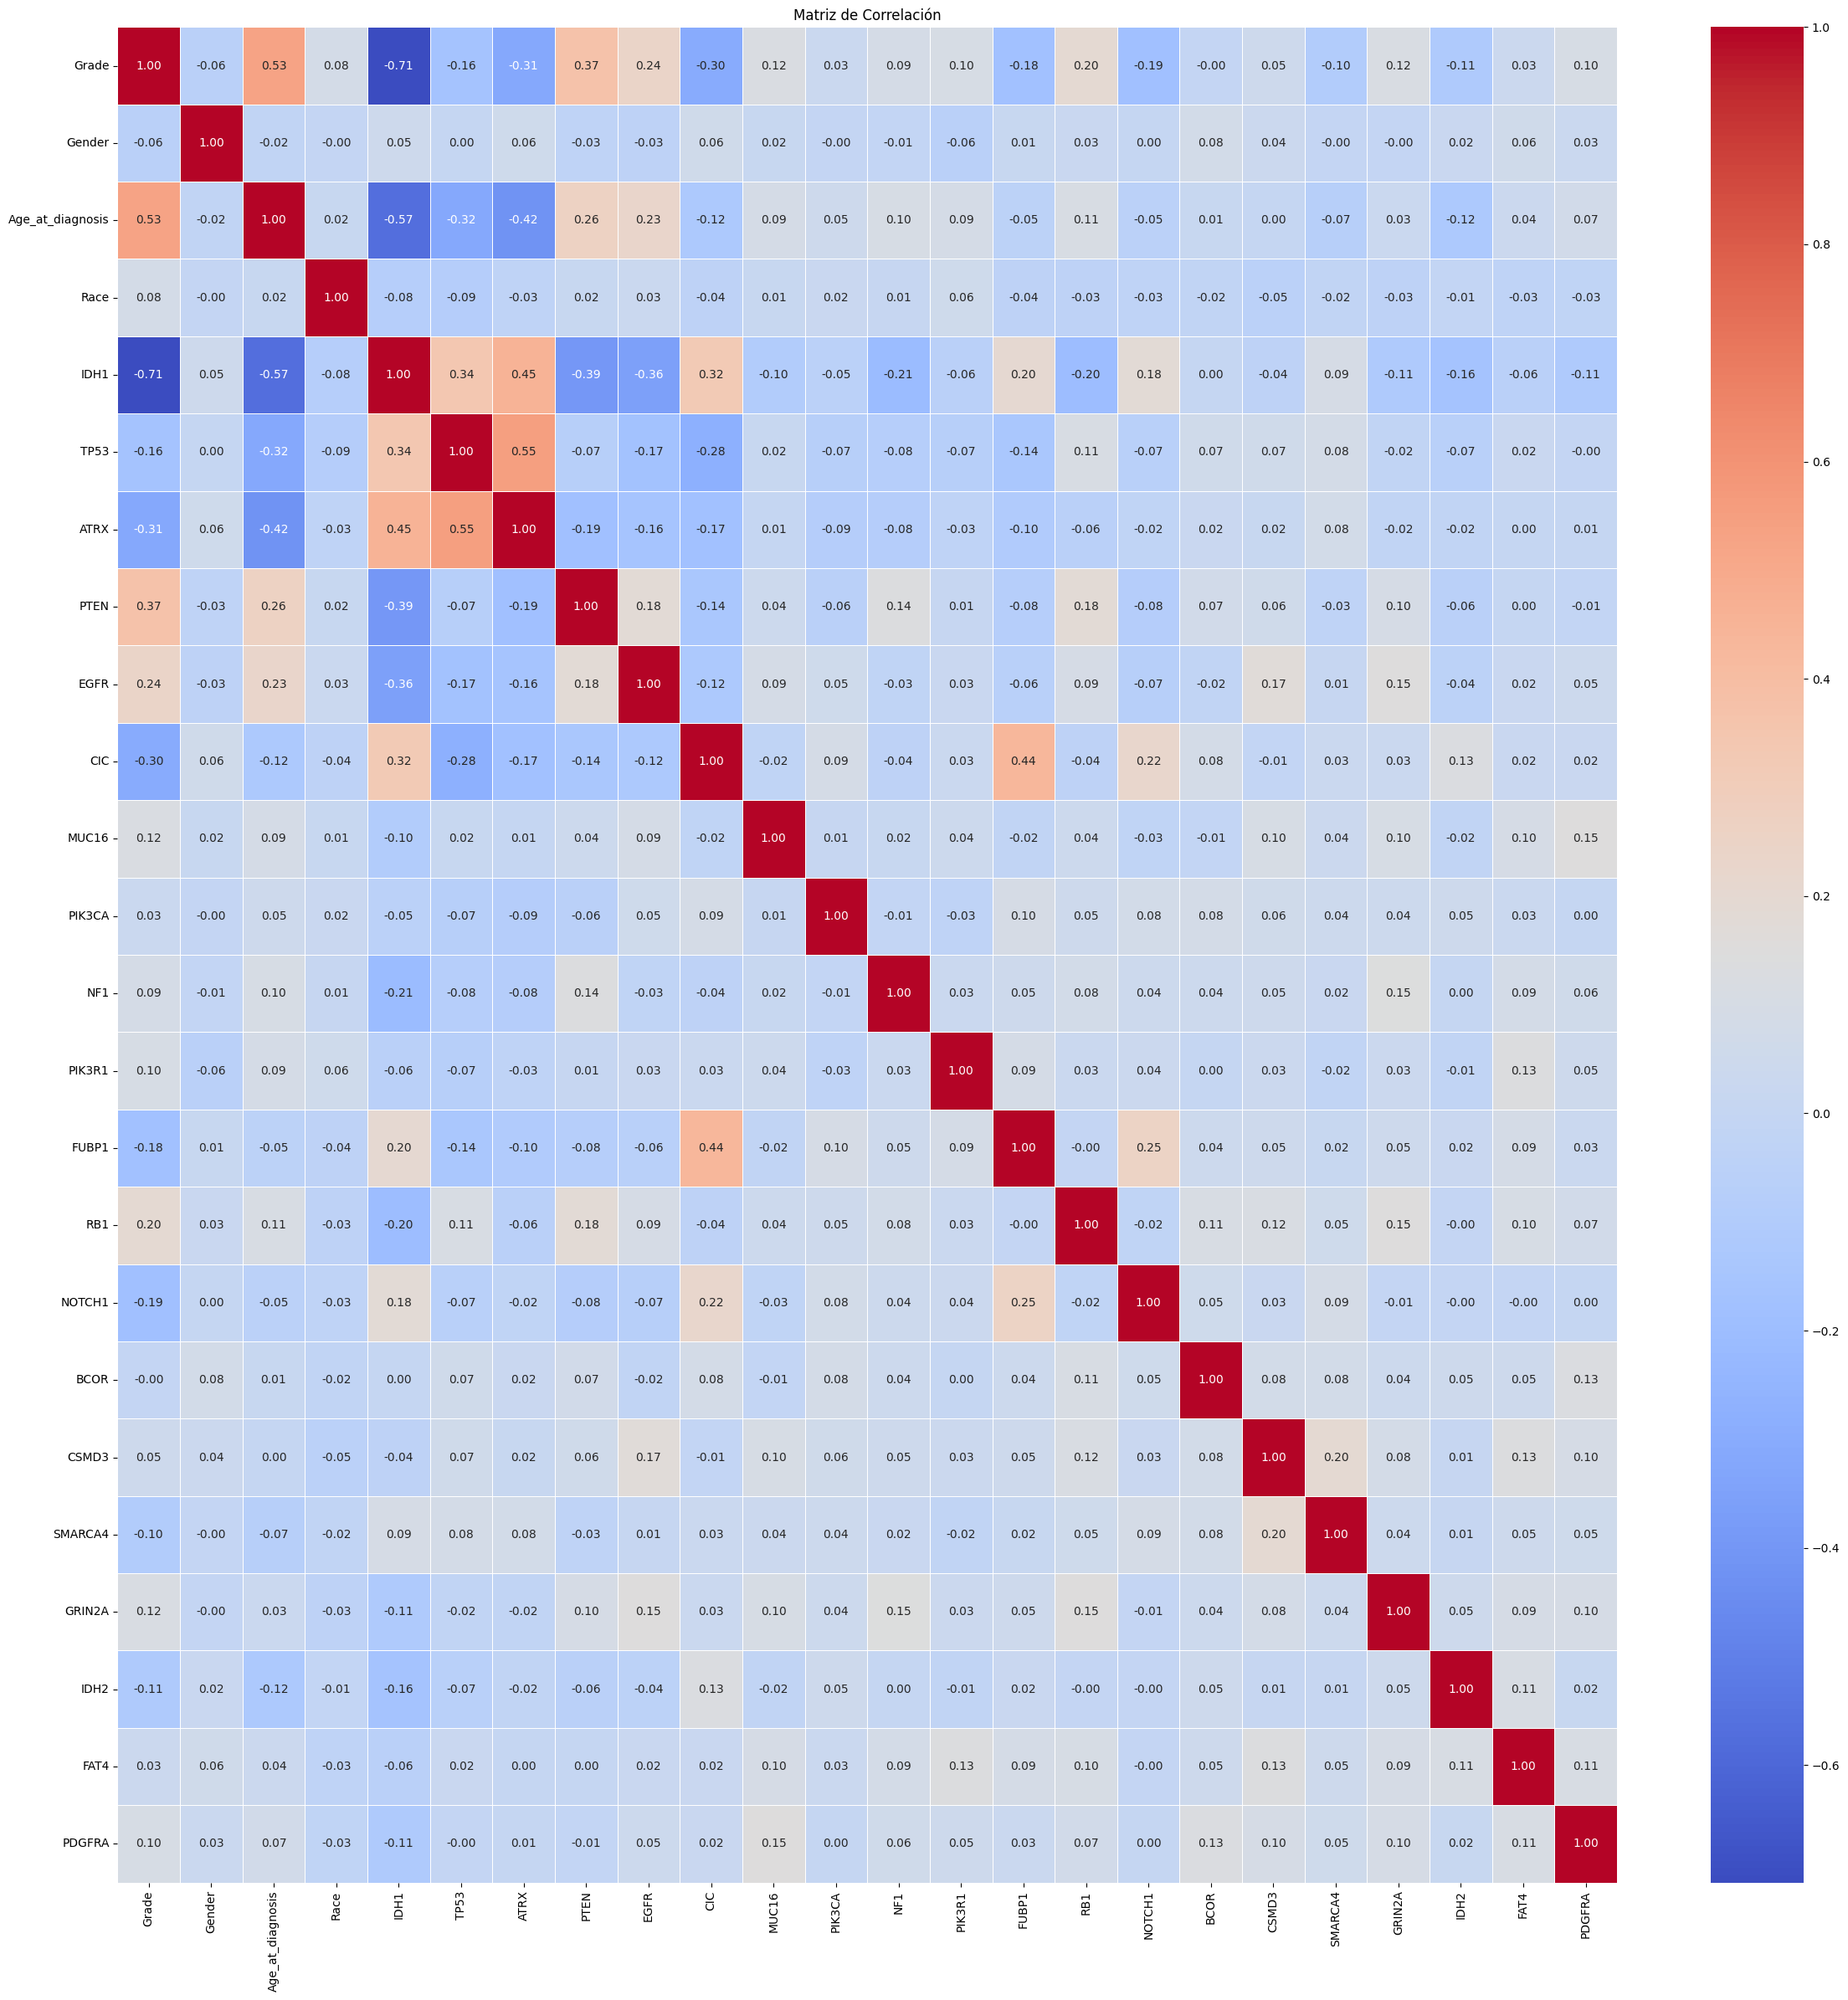

In [51]:
#Cálculo de matriz de correlación.
matriz_correlacion = df[variables_numericas].corr()

#Creación y diseño de mapa de calor.
plt.figure(figsize=(24, 24))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación")

#Impresión de mapa de calor.
plt.tight_layout()
plt.show()

* ¿Existen clases desbalanceadas? Si, la variable objetivo no tiene un balance en sus clases.

* ¿Qué atributos parecen más informativos? Tomando como base la matriz de correlación, algunos de los atributos que parecen tener más impacto son "Age_at_diagnosis, PTEN, EGFR".

## **3. Gráfica de Errores en Entrenamiento y Prueba**

Profundidad: 2
Resultados:
f1_macro: 0.8678
Profundidad: 5
Resultados:
f1_macro: 0.8606
Profundidad: 10
Resultados:
f1_macro: 0.8429
Profundidad: 15
Resultados:
f1_macro: 0.8120
Profundidad: 20
Resultados:
f1_macro: 0.8006
Profundidad: 25
Resultados:
f1_macro: 0.7890
Profundidad: 30
Resultados:
f1_macro: 0.7914
Profundidad: None
Resultados:
f1_macro: 0.7929


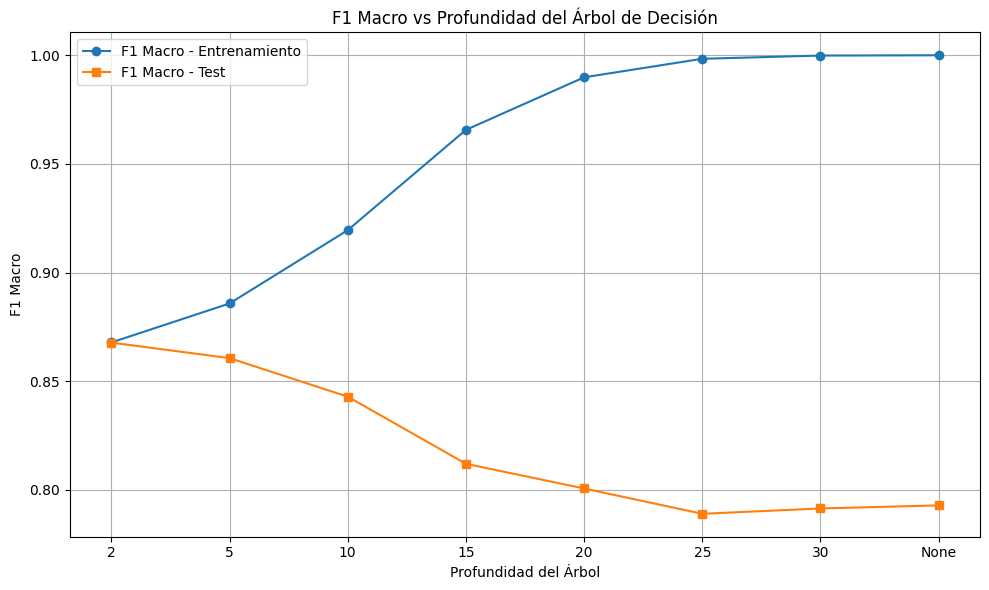

In [52]:
X = df.drop('Grade', axis=1)
y = df['Grade']
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
train_scores = []
test_scores = []

depths = [2, 5, 10, 15, 20, 25, 30, None]
scoring = ['f1_macro']
for d in depths:
    clf_cv = DecisionTreeClassifier(criterion='entropy',max_depth=d, random_state=3)

    results = cross_validate(clf_cv, X, y, cv=skf, scoring=scoring, return_train_score=True)
    print(f"Profundidad: {d}")
    print("Resultados:")
    for metric in scoring:
      print(f"{metric}: {results['test_' + metric].mean():.4f}")
    train_scores.append(results['train_f1_macro'].mean())
    test_scores.append(results['test_f1_macro'].mean())

# Etiquetas de profundidad (para el eje X)
depth_labels = [str(d) if d is not None else "None" for d in depths]

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(depth_labels, train_scores, label='F1 Macro - Entrenamiento', marker='o')
plt.plot(depth_labels, test_scores, label='F1 Macro - Test', marker='s')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('F1 Macro')
plt.title('F1 Macro vs Profundidad del Árbol de Decisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **4. Optimización de Hiperparámetros con RandomizedSearchCV**

In [53]:
#Árbol de Decisión con RandomizedSearchCV y StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint
import numpy as np

# 1. Cargar datos
X = df.drop('Grade', axis=1)
y = df['Grade']

# 2. Definir modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir espacio de búsqueda
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(5, 51, 1),
    'min_samples_split': np.arange(2, 21, 1)
}

# 4. Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=5,              # Número de combinaciones aleatorias a probar
    cv=cv,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)

# 6. Ajustar el modelo
random_search.fit(X, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor exactitud promedio (Stratified):", random_search.best_score_)

Mejores hiperparámetros encontrados: {'min_samples_split': np.int64(11), 'max_depth': np.int64(18), 'criterion': 'entropy'}
Mejor exactitud promedio (Stratified): 0.8318499774858029


## **5. Optimización de Hiperparámetros con GridSearchCV**

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Cargar el dataset
X = df.drop('Grade', axis=1)
y = df['Grade']

# 2. Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(5, 51, 1),
    'min_samples_split': np.arange(2, 21, 1)
}

# 4. Stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configurar GridSearchCV con Strafified
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# 6. Ajustar el modelo
grid_search.fit(X, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor exactitud promedio (Stratified):", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': np.int64(5), 'min_samples_split': np.int64(12)}
Mejor exactitud promedio (Stratified): 0.8641181174929005


## **6. Optimización de Hiperparámetros con RandomizedSearchCV: Accuracy**

In [55]:
#Árbol de Decisión con RandomizedSearchCV y StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint
import numpy as np

# 1. Cargar datos
X = df.drop('Grade', axis=1)
y = df['Grade']

# 2. Definir modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir espacio de búsqueda
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(5, 51, 1),
    'min_samples_split': np.arange(2, 21, 1)
}

# 4. Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configurar búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=5,              # Número de combinaciones aleatorias a probar
    cv=cv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# 6. Ajustar el modelo
random_search.fit(X, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor exactitud promedio (Stratified):", random_search.best_score_)

Mejores hiperparámetros encontrados: {'min_samples_split': np.int64(11), 'max_depth': np.int64(18), 'criterion': 'entropy'}
Mejor exactitud promedio (Stratified): 0.8367326448651748


## **7. Optimización de Hiperparámetros con GridSearchCV: Accuracy**

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Cargar el dataset
X = df.drop('Grade', axis=1)
y = df['Grade']

# 2. Definir el modelo base
clf = DecisionTreeClassifier(random_state=42)

# 3. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(5, 51, 1),
    'min_samples_split': np.arange(2, 21, 1)
}

# 4. Stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 5. Configurar GridSearchCV con Strafified
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# 6. Ajustar el modelo
grid_search.fit(X, y)

# 7. Resultados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor exactitud promedio (Stratified):", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'criterion': 'entropy', 'max_depth': np.int64(5), 'min_samples_split': np.int64(12)}
Mejor exactitud promedio (Stratified): 0.8653184165232357


## **8.Actividad de Reflexión y Análisis**

* ¿Cuál método encontró mejores hiperparámetros? Todos los métodos coinciden con el criterio, el cual corresponde a "entropy". La diferencia está entre el número de divisiones de las muestras y la profundidad, la cual es 11 y 18 respectivamente para ambos métodos de RandomizedSearchCV; 12 y 5 para ambos de GridSearchCV. En conclusión, GridSearchCV obtiene los mejores hiperparámetros ya que recorre todas las posibles combinaciones y selecciona los mejores.

* ¿Cuál fue más costoso computacionalmente? GridSearchCV tomó alrededor de 2 minutos aproximadamente en completar la ejecución de los códigos completos.

* ¿Los resultados en f1_macro set fueron distintos en ambos métodos de optimización? ¿Por qué? Ligeramente distintos. Esto se debe a la naturaleza de cada uno de los métodos; GridSearchCV recorre todas las posibles combinaciones de hierparámetros, mientras que RandomizedSearchCV hace una selección aleatoria.

* ¿Los resultados en accuracy set fueron distintos en ambos métodos de optimización? ¿Por qué? Ligeramente distintos. Esto se debe a la naturaleza de cada uno de los métodos; GridSearchCV recorre todas las posibles combinaciones de hierparámetros, mientras que RandomizedSearchCV hace una selección aleatoria.

* ¿Los valores de hiperpárametros fueron iguales en Accuracy y F1 Macro ? Si, tomando como base el mismo método de optimización.


